In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
from pathlib import Path
import numpy as np
import torch
from torch.backends import cudnn

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Configuration

In [3]:
import torch.utils.model_zoo

MOPED_PATH = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped')
LINEMOD_PATH = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/data/lm_partial')
CHECKPOINT = Path('/ssd_scratch/cvit/amoghtiwari/latentfusion/checkpoints/latentfusion-release.pth')
num_input_views = 1

In [4]:
import sys
sys.path.insert(0,'../')

##########
checkpoint = CHECKPOINT
############

In [5]:
from latentfusion.recon.inference import LatentFusionModel

model = LatentFusionModel.from_checkpoint(checkpoint, device)

2022-07-15 05:10.27 [warning  ] could not import PCL           [latentfusion.pointcloud] 
2022-07-15 05:10.31 [info     ] loaded model                   [latentfusion.recon.inference] epoch=200 name=shapenet,no_mask_morph,fixed_eqlr,256,mask,depth,in_mask,mask_noise_p=0.25,sm=nearest,fuser=gru-branched_20200509_10h19m10s-branched_20200509_10h42m53s-branched_20200509_10h46m53s-branched_20200509_10h48m49s


In [6]:
from latentfusion.recon.inference import Observation
from latentfusion.pose import bop
from latentfusion.datasets.bop import BOPDataset
from latentfusion.datasets.realsense import RealsenseDataset
import latentfusion.visualization as viz
from latentfusion.augment import gan_denormalize
from latentfusion import meshutils
from latentfusion import augment

Adding Anaconda lib path:/home/amoghtiwari/miniconda3/envs/latentfusion/lib/


## Load Dataset

### LINEMOD

Uncomment this and comment out the MOPED cell to use LINEMOD.

In [7]:
# object_id = 4
# frame = 0
# input_scene_path = LINEMOD_PATH / f'train/{object_id:06d}'
# target_scene_path = LINEMOD_PATH / f'test/{object_id:06d}'

# input_dataset = BOPDataset(LINEMOD_PATH, input_scene_path, object_id=object_id, object_scale=None)
# print('object_scale', input_dataset.object_scale)
# target_dataset = BOPDataset(LINEMOD_PATH, target_scene_path, object_id=object_id, object_scale=None)
# object_scale_to_meters = 1.0 / (1000.0 * target_dataset.object_scale)
# pointcloud = input_dataset.load_pointcloud()

### MOPED

In [8]:
object_id = 'toy_plane/'
frame = 100

input_scene_dir = MOPED_PATH / object_id / 'reference'
target_scene_dir = MOPED_PATH / object_id / 'evaluation'

pointcloud_path = input_scene_dir / 'integrated_registered_processed.obj'
obj = meshutils.Object3D(pointcloud_path)
pointcloud = torch.tensor(obj.vertices, dtype=torch.float32)
diameter = obj.bounding_diameter
object_scale = 1.0 / diameter
object_scale_to_meters = 1.0 / object_scale

input_paths = [x for x in input_scene_dir.iterdir() if x.is_dir()]
input_dataset = RealsenseDataset(input_paths,
                                 image_scale=1.0,
                                 object_scale=object_scale,
                                 odometry_type='open3d')
target_paths = sorted([x for x in target_scene_dir.iterdir() if x.is_dir()])
target_dataset = RealsenseDataset(target_paths,
                                  image_scale=1.0,
                                  object_scale=object_scale,
                                  odometry_type='open3d',
                                  use_registration=True)

scene type <class 'trimesh.base.Trimesh'>


2022-07-15 05:10.33 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/06/registration/registration.json
2022-07-15 05:10.33 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/06/registration/registration.json
2022-07-15 05:10.33 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/05/registration/registration.json
2022-07-15 05:10.33 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_plane/reference/05/registration/registration.json
2022-07-15 05:10.33 [info     ] using registration             [latentfusion.datasets.realsense] path=/ssd_scratch/cvit/amoghtiwari/latentfusion/data/moped/toy_

### Process Dataset into Observations

Here we load the data into the `Observation` class.

../latentfusion/modules/geometry.py:352: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1654413022026/work/aten/src/ATen/native/TensorShape.cpp:2890.)
  grids = bboxes_to_grid(boxes, in_size, out_size)


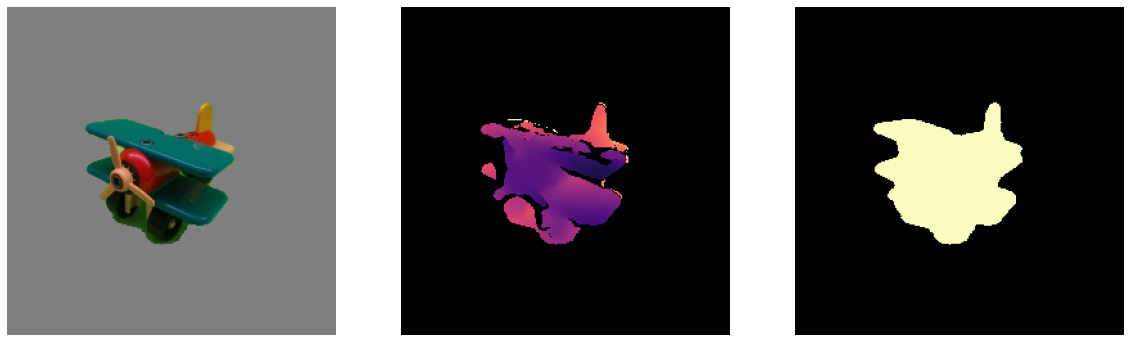

In [9]:
input_obs = Observation.from_dataset(input_dataset, inds=input_dataset.sample_evenly(num_input_views))
target_obs = Observation.from_dataset(target_dataset, inds=list(range(len(target_dataset)))[frame:frame+1])

input_obs_pp = model.preprocess_observation(input_obs)
input_obs_pp_gt = model.preprocess_observation(input_obs)
target_obs_pp = model.preprocess_observation(target_obs)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(gan_denormalize(input_obs_pp.color), nrow=4)
plt.subplot(132)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(input_obs_pp.mask), nrow=4)

## Build Latent Object

This builds the 'latent object', referred to as `z_obj` in this code.

recon_error 0.040298305451869965


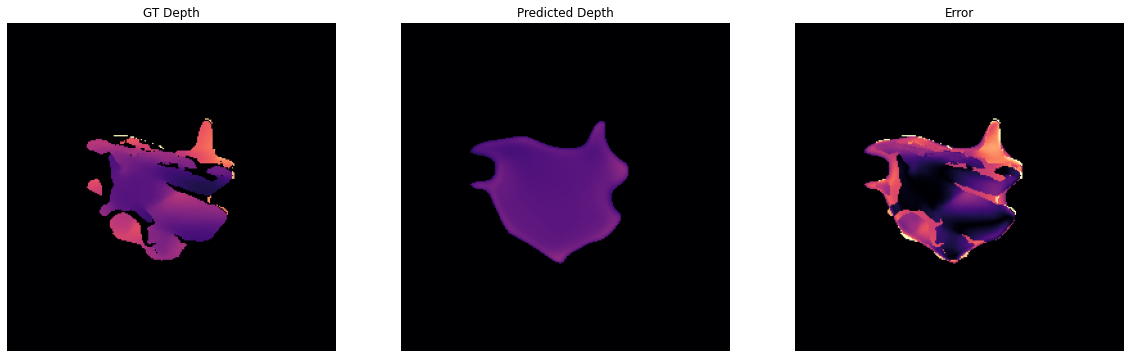

In [10]:
from latentfusion import three
import math

with torch.no_grad():
    z_obj = model.build_latent_object(input_obs_pp)
    # Visualize prediction.
    camera = input_obs_pp.camera.clone()
    y, z = model.render_latent_object(z_obj, camera.to(device))
recon_error = (y['depth'].detach().cpu() - input_obs_pp_gt.depth).abs()
print('recon_error', recon_error.mean().item())
    
plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(input_obs_pp.depth), nrow=4, title='GT Depth')
plt.subplot(132)
viz.show_batch(viz.colorize_depth(y['depth'].detach().cpu()), nrow=4, title='Predicted Depth')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(recon_error), nrow=4, title='Error')


### Visualize some novel views

This visualizes the object from novel views.

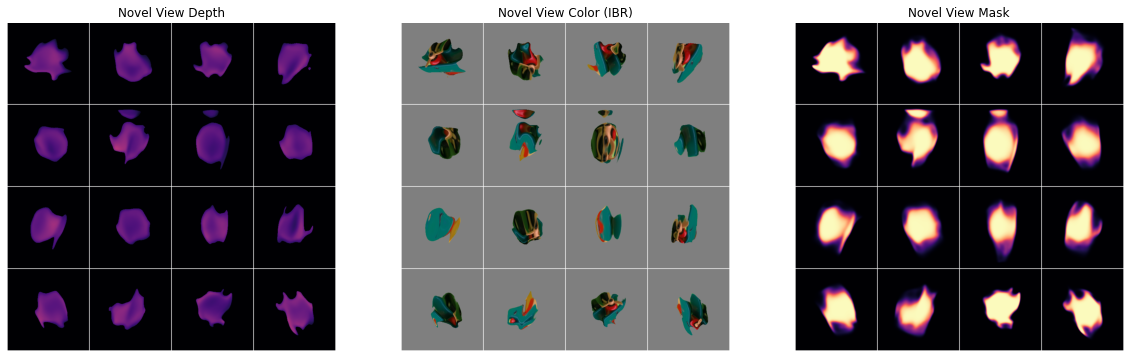

In [11]:
from latentfusion.three.orientation import evenly_distributed_quats
num_novel = 16
camera_ref = input_obs.camera[0]
camera_ref = camera_ref.zoom(None, model.camera_dist, model.input_size)
quats = evenly_distributed_quats(num_novel, upright=True).to(device)
camera_test = camera_ref.clone().repeat(num_novel)
camera_test.quaternion = quats

with torch.no_grad():
    y, _ = model.render_ibr_basic(z_obj, input_obs, camera_test.clone().to(device), apply_mask=True)

plt.figure(figsize=(20, 10))
plt.subplot(131)
viz.show_batch(viz.colorize_depth(y['depth']), nrow=4, title='Novel View Depth')
plt.subplot(132)
viz.show_batch(gan_denormalize(y['color'].cpu()), nrow=4, title='Novel View Color (IBR)')
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(y['mask']), nrow=4, title='Novel View Mask')

## Coarse Pose Estimation

2022-07-15 05:10.42 [info     ] loading pose estimator from config [latentfusion.pose.estimation] init_hemisphere=False init_upright=False learning_rate=0.3 loss_weights={'depth': 0.0, 'ov_depth': 0.0, 'iou': 0.0, 'mask': 0.0, 'latent': 1.0} num_elites=48 num_gmm_components=6 num_iters=30 num_samples=96 ranking_size=16 return_camera_history=False sample_flipped=True type=cross_entropy verbose=False


from latentfusion/pose/estimation, camera_init:  Camera(count=1)
from latentfusion/pose/estimation, target_obs:  <latentfusion.observation.Observation object at 0x1525e9874250>
from latentfusion/three/quaternion, q1, q2 tensor([[1., 0., 0., 0.]]) tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]])
from latentfusion/pose/estimation: Rotn dist tensor([[0.5193]])
from latentfusion/three/quaternion, q1, q2 tensor([[1., 0., 0., 0.]]) tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]])
from latentfusion/pose/estimation: Rotn dist degrees tensor([[293.6410]])


2022-07-15 05:10.58 [info     ] best camera                    [latentfusion.pose.estimation] loss=0.06566667556762695 step=12


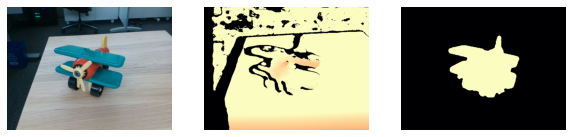

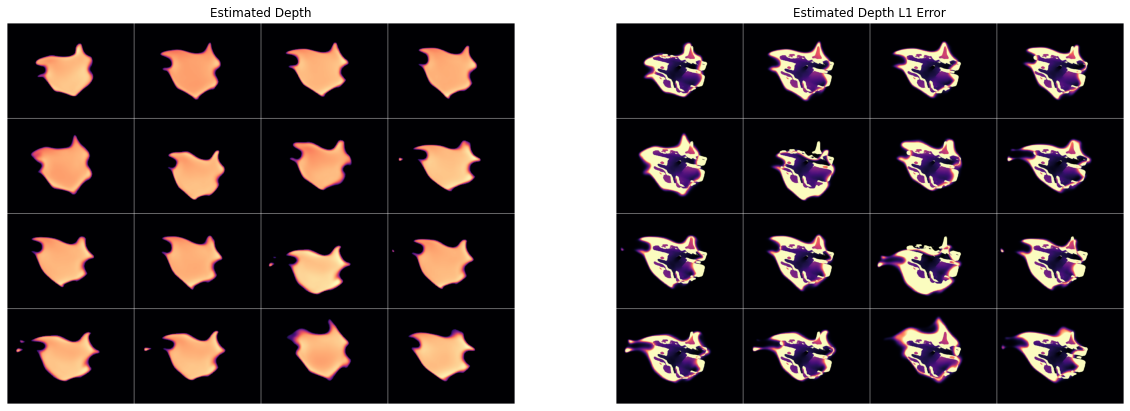

In [12]:
import latentfusion.pose.estimation as pe
from functools import partial

# estimator = pe.load_from_config('../configs/cross_entropy_latent.toml', model, return_camera_history=False, verbose=False)
estimator = pe.load_from_config('../configs/cross_entropy_latent.toml', model, return_camera_history=False, verbose=False)

coarse_camera = estimator.estimate(z_obj, target_obs[0])
camera_zoom = coarse_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.
pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * pred_mask
pred_depth, _ = camera_zoom.uncrop(pred_depth)
pred_mask, _ = camera_zoom.uncrop(pred_mask)
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()

plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth.cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask.cpu()), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

### Fine Pose Estimation

In [13]:
# from latentfusion.pose.metrics import camera_rotation_dist

In [14]:
# target_obs.device

In [15]:
# camera_rotation_dist(init_camera[0].to('cpu'), target_obs.camera) * 180 / math.pi
# camera_rotation_dist(init_camera[0], init_camera[0])


In [16]:
# target_obs[0].camera

In [17]:
import pickle as pkl

In [18]:
# with open("coarse_camera.pkl", "wb") as f:
#     pkl.dump(coarse_camera, f)
    

In [19]:
# coarse_camera

In [20]:
with open("coarse_camera.pkl", "rb") as f:
    coarse_camera = pkl.load(f)
    

In [21]:
coarse_camera

Camera(count=16)

2022-07-15 05:11.00 [info     ] loading pose estimator from config [latentfusion.pose.estimation] converge_patience=10 converge_threshold=1e-06 learning_rate=0.01 loss_weights={'depth': 1.0, 'ov_depth': 0.3, 'iou': 0.0, 'mask': 0.0, 'latent': 0.0} lr_reduce_patience=10 lr_reduce_threshold=0.0001 num_iters=100 num_samples=8 optimizer=adam ranking_size=8 return_camera_history=True track_stats=True type=gradient


from latentfusion/three/quaternion, q1, q2 tensor([[-9.8223e-01,  7.6098e-02,  1.5503e-01,  7.3514e-02],
        [ 9.8361e-01, -9.9846e-02, -8.2182e-02, -1.2567e-01],
        [ 9.9496e-01, -5.9485e-05, -2.0309e-02, -9.8178e-02],
        [-9.8772e-01, -3.8700e-02,  1.0429e-01,  1.0967e-01],
        [ 9.6851e-01,  5.1193e-02, -2.3157e-01, -7.5744e-02],
        [ 9.6437e-01, -2.8768e-02, -1.8140e-01, -1.9042e-01],
        [-9.7551e-01,  1.1363e-01,  1.7770e-01,  6.2378e-02],
        [-9.9728e-01,  5.1425e-02, -7.4462e-03,  5.2233e-02],
        [-9.9969e-01,  2.3901e-02,  6.3048e-03, -8.0342e-04],
        [ 9.6094e-01, -8.7650e-02, -1.3671e-01, -2.2409e-01],
        [ 9.6384e-01,  1.5899e-02, -1.6036e-01, -2.1225e-01],
        [-9.9993e-01, -7.3687e-04, -3.8703e-03,  1.1177e-02],
        [ 9.9823e-01, -5.5493e-02, -1.8081e-02, -1.1028e-02],
        [ 9.6628e-01, -1.4584e-01, -1.9599e-01, -8.1312e-02],
        [-9.7604e-01,  1.5306e-01,  1.7930e-02,  1.5363e-01],
        [-9.6063e-01,  1.20

        [-0.9855,  0.0747,  0.0830,  0.1281]], device='cuda:0') tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]], device='cuda:0')
from latentfusion/three/quaternion, q1, q2 tensor([[-0.9926,  0.0495,  0.0997,  0.0486],
        [ 0.9867, -0.0289, -0.1169, -0.1090],
        [ 0.9891, -0.0580, -0.0940, -0.0973],
        [-0.9796, -0.0466,  0.1363,  0.1404],
        [ 0.9811, -0.0253, -0.1643, -0.0995],
        [ 0.9826,  0.0268, -0.1368, -0.1225],
        [-0.9913,  0.0681,  0.1053,  0.0389],
        [-0.9910,  0.0936, -0.0142,  0.0950],
        [-0.9972,  0.0728,  0.0185, -0.0010],
        [ 0.9785, -0.0166, -0.1398, -0.1507],
        [ 0.9703, -0.0105, -0.1930, -0.1453],
        [-0.9994, -0.0023, -0.0117,  0.0333],
        [ 0.9922, -0.0709, -0.0826, -0.0605],
        [ 0.9844, -0.0773, -0.1223, -0.1002],
        [-0.9934,  0.0807,  0.0119,  0.0810],
        [-0.9875,  0.0695,  0.0772,  0.1189]], device='cuda:0') tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]], device='cuda:0')
from latent

        [-9.8989e-01,  6.2276e-02,  6.9840e-02,  1.0659e-01]], device='cuda:0') tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]], device='cuda:0')
from latentfusion/three/quaternion, q1, q2 tensor([[-9.8798e-01,  6.2279e-02,  1.2724e-01,  6.1925e-02],
        [ 9.8749e-01, -2.2720e-03, -1.2294e-01, -9.8729e-02],
        [ 9.8369e-01, -7.4364e-02, -1.3197e-01, -9.6948e-02],
        [-9.7953e-01, -4.5338e-02,  1.3727e-01,  1.4008e-01],
        [ 9.8467e-01, -5.5200e-02, -1.2571e-01, -1.0758e-01],
        [ 9.9064e-01, -2.1141e-02, -1.0831e-01, -8.0280e-02],
        [-9.8790e-01,  7.9636e-02,  1.2455e-01,  4.6821e-02],
        [-9.9361e-01,  7.8827e-02, -1.0514e-02,  8.0081e-02],
        [-9.9830e-01,  5.6476e-02,  1.4579e-02,  3.5606e-04],
        [ 9.8731e-01, -6.8257e-03, -1.3687e-01, -8.0270e-02],
        [ 9.8374e-01, -6.4283e-02, -1.4760e-01, -7.9640e-02],
        [-9.9770e-01, -4.7100e-03, -2.2577e-02,  6.3674e-02],
        [ 9.8369e-01, -6.3775e-02, -1.3968e-01, -9.3685e-02],
       

        [-9.8729e-01,  6.9309e-02,  7.8880e-02,  1.1934e-01]], device='cuda:0') tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]], device='cuda:0')
from latentfusion/three/quaternion, q1, q2 tensor([[-9.8304e-01,  7.2978e-02,  1.5111e-01,  7.3955e-02],
        [ 9.8732e-01, -2.8141e-02, -1.3544e-01, -7.7892e-02],
        [ 9.8443e-01, -7.7513e-02, -1.3382e-01, -8.3573e-02],
        [-9.9015e-01, -3.1990e-02,  9.5735e-02,  9.7016e-02],
        [ 9.8910e-01, -7.0502e-02, -1.1053e-01, -6.7007e-02],
        [ 9.8486e-01, -7.9223e-02, -1.3440e-01, -7.5627e-02],
        [-9.8160e-01,  9.7003e-02,  1.5353e-01,  5.9005e-02],
        [-9.9118e-01,  9.2646e-02, -1.1161e-02,  9.4087e-02],
        [-9.9986e-01,  1.5983e-02,  4.2602e-03,  2.8426e-04],
        [ 9.8851e-01, -3.2645e-02, -1.3309e-01, -6.3827e-02],
        [ 9.8510e-01, -1.0542e-01, -1.1659e-01, -6.9812e-02],
        [-9.9897e-01, -2.6941e-03, -1.4951e-02,  4.2759e-02],
        [ 9.8215e-01, -6.5472e-02, -1.4115e-01, -1.0567e-01],
       

2022-07-15 05:11.07 [info     ] convergence patience threshold reached [latentfusion.pose.estimation] count=10 delta=0.0 step=29


2022-07-15 05:11.07 [info     ] best camera                    [latentfusion.pose.estimation] loss=0.08282218873500824 step=19


from latentfusion/pose/estimation.py, cameras: 
 tensor([[[ 0.9471,  0.2077, -0.2446,  0.0765],
         [-0.1705,  0.9715,  0.1647, -0.0480],
         [ 0.2719, -0.1143,  0.9555,  1.7667],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9466,  0.2092, -0.2451,  0.0800],
         [-0.1714,  0.9710,  0.1667, -0.0494],
         [ 0.2729, -0.1158,  0.9551,  1.7595],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9478,  0.2048, -0.2446,  0.0734],
         [-0.1676,  0.9721,  0.1642, -0.0475],
         [ 0.2714, -0.1147,  0.9556,  1.7734],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9486,  0.2003, -0.2452,  0.0708],
         [-0.1627,  0.9727,  0.1653, -0.0478],
         [ 0.2716, -0.1169,  0.9553,  1.7794],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9532,  0.1491, -0.2629,  0.0688],
         [-0.1266,  0.9868,  0.1006, -0.0464],
         [ 0.2744, -0.0626,  0.9596,  1.7866],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

 

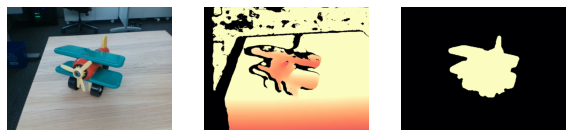

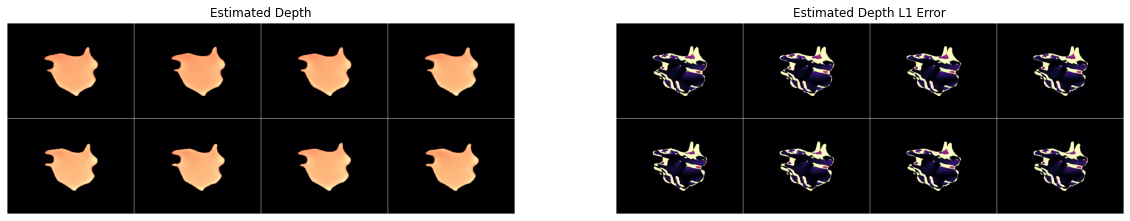

In [22]:
from latentfusion import utils
from latentfusion.pose import utils as pose_utils
from latentfusion.modules.geometry import Camera

sgd_estimator = pe.load_from_config('../configs/adam_quick.toml', model, track_stats=True, return_camera_history=True, num_iters=100)

init_camera = coarse_camera.clone()
refined_camera, stat_history, camera_history = sgd_estimator.estimate(z_obj, target_obs[0], camera=init_camera)
# refined_camera, stat_history, camera_history = sgd_estimator.estimate(z_obj, target_obs[0])
camera_zoom = refined_camera.zoom(None, model.camera_dist, model.input_size)

# Visualize prediction.

pred_y, pred_z = model.render_latent_object(z_obj, camera_zoom.to(device))
pred_mask = pred_y['mask'].squeeze(0)
pred_depth = pred_y['depth'].squeeze(0)
pred_depth = camera_zoom.denormalize_depth(pred_depth) * (pred_y['mask'].squeeze(0) > 0.5)
pred_depth, _ = camera_zoom.uncrop(pred_depth)

pred_mask, _ = camera_zoom.uncrop(pred_mask)
depth_error = (target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()
pred_depth = pred_depth.cpu()
pred_mask = pred_mask.cpu()
depth_error = depth_error.cpu()

plt.figure(1, figsize=(10, 10))
plt.subplot(131)
viz.show_batch(target_obs.color[0], nrow=2)
plt.subplot(132)
viz.show_batch(viz.colorize_tensor(target_obs[0].depth, cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=2)
plt.subplot(133)
viz.show_batch(viz.colorize_tensor(target_obs.prepare()[0].mask), nrow=2)

plt.figure(2, figsize=(20, 10))
plt.subplot(121)
viz.show_batch(viz.colorize_tensor(pred_depth.detach().cpu(), cmin=pred_depth.max()-1, cmax=pred_depth.max()), nrow=4, title="Estimated Depth")

plt.subplot(122)
viz.show_batch(viz.colorize_tensor((target_obs.prepare()[0].depth - pred_depth.detach().cpu()).abs()), nrow=4, title="Estimated Depth L1 Error")

In [23]:
from latentfusion.pose.metrics import camera_metrics
from latentfusion.pose.format import metrics_table_multiple


for j in range(1):
    print(metrics_table_multiple([
            camera_metrics(target_obs.camera, coarse_camera[j], pointcloud, object_scale_to_meters),
            camera_metrics(target_obs.camera, refined_camera[j], pointcloud, object_scale_to_meters),
    ], ['Coarse', 'Refined'], tablefmt='simple'))

Camera gt from latentfusion/pose/metrics.py tensor([[[ 0.8690,  0.2777, -0.4097,  0.0221],
         [-0.2608,  0.9604,  0.0978, -0.0674],
         [ 0.4206,  0.0218,  0.9070,  1.7888],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
Camera eval from latentfusion/pose/metrics.py tensor([[[ 0.9411,  0.1680, -0.2934,  0.0752],
         [-0.1208,  0.9776,  0.1723, -0.0768],
         [ 0.3157, -0.1267,  0.9403,  1.5713],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
from latentfusion/three/quaternion, q1, q2 tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]]) tensor([[-0.9822,  0.0761,  0.1550,  0.0735]])
Camera gt from latentfusion/pose/metrics.py tensor([[[ 0.8690,  0.2777, -0.4097,  0.0221],
         [-0.2608,  0.9604,  0.0978, -0.0674],
         [ 0.4206,  0.0218,  0.9070,  1.7888],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
Camera eval from latentfusion/pose/metrics.py tensor([[[ 0.9471,  0.2077, -0.2446,  0.0765],
         [-0.1705,  0.9715,  0.1647, -0.0480],
         [ 0.2719, 

### Plot pose refinement stats over time

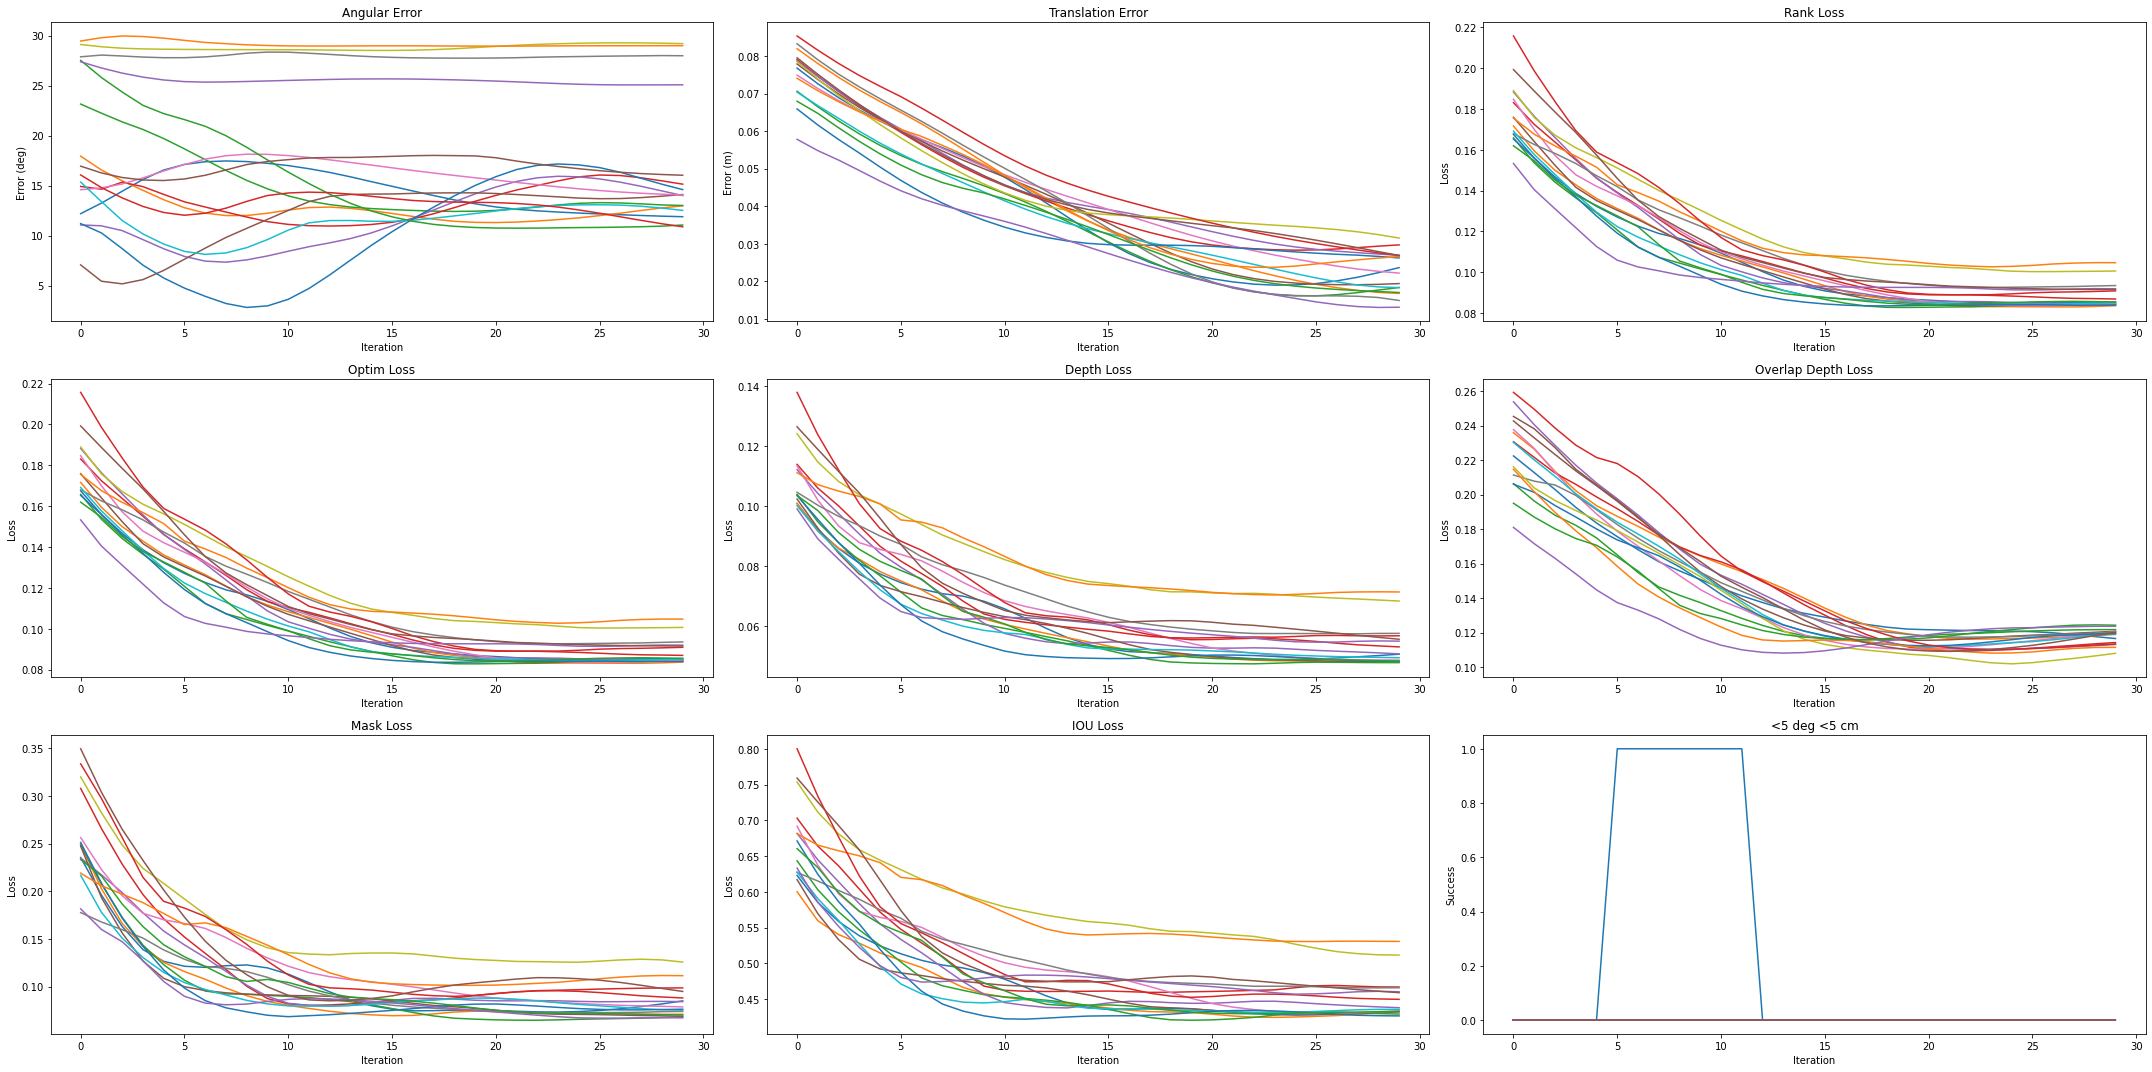

In [24]:
import math

viz.plot_grid(3, figsize=(30, 15), plots=[
    viz.Plot('Angular Error', [stat_history['angle_dist']/math.pi*180], 
             params={'ylabel': 'Error (deg)', 'xlabel': 'Iteration'}),
    viz.Plot('Translation Error', [stat_history['trans_dist']*object_scale_to_meters], 
             params={'ylabel': 'Error (m)', 'xlabel': 'Iteration'}),
    viz.Plot('Rank Loss', [stat_history['rank_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Optim Loss', [stat_history['optim_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    
    viz.Plot('Depth Loss', [stat_history['depth_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Overlap Depth Loss', [stat_history['ov_depth_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('Mask Loss', [stat_history['mask_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('IOU Loss', [stat_history['iou_loss']], 
             params={'ylabel': 'Loss', 'xlabel': 'Iteration'}),
    viz.Plot('<5 deg <5 cm', [(stat_history['trans_dist']*object_scale_to_meters < 0.05) & (stat_history['angle_dist']/math.pi*180 < 5)], 
             params={'ylabel': 'Success', 'xlabel': 'Iteration'}),
]);

In [25]:
refined_camera[0].extrinsic

tensor([[[ 0.9471,  0.2077, -0.2446,  0.0765],
         [-0.1705,  0.9715,  0.1647, -0.0480],
         [ 0.2719, -0.1143,  0.9555,  1.7667],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [26]:
coarse_camera[0].extrinsic

tensor([[[ 0.9411,  0.1680, -0.2934,  0.0752],
         [-0.1208,  0.9776,  0.1723, -0.0768],
         [ 0.3157, -0.1267,  0.9403,  1.5713],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')

In [27]:
target_obs[0].camera.extrinsic 

tensor([[[ 0.8690,  0.2777, -0.4097,  0.0221],
         [-0.2608,  0.9604,  0.0978, -0.0674],
         [ 0.4206,  0.0218,  0.9070,  1.7888],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [28]:
target_obs[0].camera

Camera(count=1)

In [29]:
len(camera_history[0][0])

16

In [30]:
camera_history[0][1][0].extrinsic

tensor([[[ 0.9411,  0.1680, -0.2934,  0.0752],
         [-0.1208,  0.9776,  0.1723, -0.0768],
         [ 0.3157, -0.1267,  0.9403,  1.5713],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [31]:
target_obs.camera.quaternion

tensor([[ 0.9665, -0.0196, -0.2148, -0.1393]])

In [32]:
coarse_camera[0].quaternion

tensor([[-0.9822,  0.0761,  0.1550,  0.0735]], device='cuda:0')